### Loading packages

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import time
import warnings
import os

In [2]:
# set seed to control sources of randomness for reproducibilty
np.random.seed(5);   
torch.manual_seed(5);

### Discretized example problem

In [3]:
import OCP

# name problem
problem_type = 'HighDimBilinCtrlZeroTarget'

# choose dimension
n = 40

# choose reaction term
#rxn = None
rxn = 'hyperbolic'
#rxn = 'logistic'

# choose control term
#ctrl=None
#ctrl = 'add'
ctrl = 'bilin'

# choose indicator function for additive control
#ind_fun = (0.25, 0.5)
#ind_fun = (0.25, 0.75)

# choose target
target = OCP.zero
#target = OCP.quadratic
#target = OCP.polynomial
#target = OCP.sin   
#target = OCP.quadratic_cos

# choose coefficients for system and cost
system_coeff = {'a':0.02, 'b':1., 'c':1.}
cost_coeff = {'alpha':1., 'beta':0.1, 'gamma':2.}

# choose initial and final time, 1D space and initial condition domain
#t=(0.,5.)
#Omega=(0.,1.)
#X0=(-1.5,1.5))

# initialize problem
problem = OCP.ControlledReactionDiffusionSystem(n, rxn=rxn, ctrl=ctrl, target=target, 
                                                system_coeff=system_coeff, cost_coeff=cost_coeff)

# save problem and its configurations
problem.save_config(problem_type)
problem.save_problem(problem_type)

### Initial data generation

In [4]:
import BVP
import data_generation

# choose number of trajectories in initial training set and validation set
num_train_samples = 5 
num_val_samples = 5

# choose time-marching sequence
init_config = {'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}

# generate initial training data using time-marching
X0_samples = data_generation.sample_X0(problem, num_samples=num_train_samples)
print('------------------------------------\n Initial Training Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                                                       init_config=init_config)
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'train')

# generate validation data using time-marching
X0_samples = data_generation.sample_X0(problem, num_samples=num_val_samples)
print('------------------------------------\n Validation Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                                                       init_config=init_config)
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'val')

------------------------------------
 Initial Training Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 5 generating 1261 data points (from 1173 initially guessed points)
solution time:       22.264950 of which 4.215861 solving BVP
solution time per data point: 0.017657

------------------------------------
 Validation Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 5 generating 1255 data points (from 1172 initially guessed points)
solution time:       23.225951 of which 4.234102 solving BVP
solution time per data point: 0.018507



### Neural network model

In [5]:
import NN

# name model
model_type = 'ResidualForcedFinalConditionNet'

# set hyperparameters
depth = 4
width = 100

#activation = nn.Tanh()        
#activation = nn.ReLU()         
activation = nn.Softplus()

#architecture = 'feedforward'  
architecture = 'residual'

# get cpu or gpu device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device\n')

# initialize model
#model = NN.FeedforwardNet(n, depth, width, activation, device).to(device)
model = NN.NeuralNet(n, depth, width, activation, architecture, device).to(device)
model = NN.ForcedFinalConditionNet(model, problem)

# print model and its parameters
print('------------------------------------\n Neural Network Model\n------------------------------------')
print(model)

using cpu device

------------------------------------
 Neural Network Model
------------------------------------
ForcedFinalConditionNet(
  (model): NeuralNet(
    (activation): Softplus(beta=1, threshold=20)
    (input_layer): Linear(in_features=41, out_features=100, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
    )
    (output_layer): Linear(in_features=100, out_features=1, bias=True)
  )
  (activation): Softplus(beta=1, threshold=20)
)


### Training with adaptive data generation

In [6]:
import NN_optimization

# name training
train_type = 'AdamTimeStopped'

# initialize optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
#optimizer = torch.optim.LBFGS(model.parameters())

# choose batch size
batch_size = 100
#batch_size = 'full'

# choose gradient regularization weight
#grad_reg = 0.
grad_reg = 100.

# choose early stopping, data set size selection and convergence parameters
#criterion = 'GL' 
criterion = 'PQ'
#criterion = 'UP'
error_metric = [0., 0., 1.]
#error_metric = [1., grad_reg, 0.]
stop_params = {'error_metric':error_metric, 'strip':5, 'num_strips':1, 
               'max_iter':50, 'min_progress':0.01, 'criterion':criterion, 'stop_tol':0.1}
select_params = {'subset_size':None, 'conv_tol':1e-4, 'growth_ub':1.25}
max_epoch = 200
max_time = 100.

# save partially trained models
partial_train_times = [float('inf')]
#partial_train_times = [5, 100, float('inf')] 
current_train_phase = 0
partial_train_type = train_type + 'PartialTrain' + str(partial_train_times[current_train_phase])

# initialize training and convergence
training = NN_optimization.NetTraining(optimizer, batch_size, grad_reg=grad_reg, 
                                       max_epoch=max_epoch, max_time=max_time,
                                       stop_params=stop_params, select_params=select_params)

# save model configurations
model.save_config(problem_type, model_type, train_type)

# save training configurations
training.save_config(problem_type, model_type, train_type)

In [7]:
start_train_time = time.time()

# loop for convergence test and data generation
while True:
    # create data set
    train_data = data_generation.OCPDataset(problem_type, 'train')
    val_data = data_generation.OCPDataset(problem_type, 'val')

    # create dataloader
    if training.batch_size == 'full':
        train_dataloader = DataLoader(train_data, batch_size=len(train_data))
        val_dataloader = DataLoader(val_data, batch_size=len(val_data))    
    else:
        train_dataloader = DataLoader(train_data, batch_size=training.batch_size, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=training.batch_size, shuffle=True)

    # loop for training with fixed data set
    while True:
        training.current_epoch += 1
        print(f'------------------------------------\n Epoch {training.current_epoch}\n------------------------------------')
        
        # track number of training data
        num_train_data = len(train_data)
        training.num_train_data.append(num_train_data)
        
        # train model
        training.train(train_dataloader, model)
        print('')
        
        # compute relative errors
        print('training errors:')
        training.train_errors = np.hstack((training.train_errors, training.validate(train_dataloader, problem, model)))
        print('validation errors:')
        training.val_errors = np.hstack((training.val_errors, training.validate(val_dataloader, problem, model)))
        print('')
        
        # update optimal epoch and check early stopping criterion to prevent overfitting
        stop = training.early_stop()
        print('')
        
        # save model parameters of optimal epoch
        if training.opt_epoch == training.current_epoch:
            model.save_model(problem_type, model_type, train_type) 
        
        # track training time
        end_train_time = time.time()
        training.train_times.append(end_train_time - start_train_time)
        start_train_time = time.time()
        
        # save partially trained model
        if sum(training.train_times) >= partial_train_times[current_train_phase]:
            partial_train_model = NN.load_model(problem_type, model_type, train_type)
            partial_train_model.save_model(problem_type, model_type, partial_train_type) 
            current_train_phase += 1
            partial_train_type = train_type + 'PartialTrain' + str(partial_train_times[current_train_phase])
        
        # stop iterations
        if stop or training.current_epoch >= training.max_epoch or sum(training.train_times) >= training.max_time:
            training.stop_epochs.append(training.current_epoch)
            break
    
    if training.current_epoch >= training.max_epoch:
        print('Training terminated: maximum number of epochs is exceeded')
        break
        
    if sum(training.train_times) >= training.max_time:
        print('Training terminated: maximum time limit is exceeded')
        break
    
    # compute adaptive subset size for approximation of convergence criterion
    training.select_params['subset_size'] = int(100 * np.log(num_train_data/100 + 1))
    
    # select data set size
    new_num_train_data = training.select_dataset_size(train_data, model)
    training.generation_ratios.append(new_num_train_data/num_train_data)
    
    if new_num_train_data == num_train_data:
        print('Training terminated: convergence criterion is satisfied')
        break

    # generate data adaptively
    print('------------------------------------\n Adaptive Data Generation\n------------------------------------')
    # reset Adam
    #training.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
    while new_num_train_data > num_train_data and (sum(training.train_times) + time.time() - start_train_time) < training.max_time:
        # sample and select initial conditions with largest gradient norm
        X0_candidates = data_generation.sample_X0(problem, num_samples=10)
        X0_sample = data_generation.select_X0(problem, model, X0_candidates, num_top=1)
        
        # solve BVP with NN warm start
        solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
        t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_sample, initialization='NN_warm_start', 
                                                           init_config={'model':model}, solver_config=solver_config)
        # track number of generated data
        num_train_data += len(t_data)
        print(f'data generated: {num_train_data} / {new_num_train_data} \n')
        
        # add new data to saved data
        data_generation.update_data(t_data, X_aug_data, idx_samples, problem_type, 'train')
    
    if (sum(training.train_times) + time.time() - start_train_time) >= max_time:
        print('Training terminated: maximum time limit is exceeded')
        break

end_train_time = time.time()
training.train_times.append(end_train_time - start_train_time)
        
# save training instance
training.save_training(problem_type, model_type, train_type)

------------------------------------
 Epoch 1
------------------------------------
total loss: 4.579531, value loss: 0.115302, grad loss: 0.044642 [    0/ 1261]
total loss: 4.089809, value loss: 0.068979, grad loss: 0.040208 [ 1000/ 1261]

training errors:
value RMAE: 7.613936, grad RML1: 3.417446, ctrl RMAE: 9.904089
validation errors:
value RMAE: 3.914830, grad RML1: 3.250682, ctrl RMAE: 6.037319

generalization loss: 0.000000

------------------------------------
 Epoch 2
------------------------------------
total loss: 4.598133, value loss: 0.110500, grad loss: 0.044876 [    0/ 1261]
total loss: 4.255143, value loss: 0.067951, grad loss: 0.041872 [ 1000/ 1261]

training errors:
value RMAE: 7.667542, grad RML1: 3.333463, ctrl RMAE: 9.542969
validation errors:
value RMAE: 3.845290, grad RML1: 3.202658, ctrl RMAE: 5.948513

generalization loss: 0.000000

------------------------------------
 Epoch 3
------------------------------------
total loss: 3.746390, value loss: 0.064551, grad 

total loss: 0.141491, value loss: 0.029285, grad loss: 0.001122 [ 1000/ 1261]

training errors:
value RMAE: 6.662284, grad RML1: 0.633916, ctrl RMAE: 0.338666
validation errors:
value RMAE: 3.052186, grad RML1: 2.297681, ctrl RMAE: 4.247263

generalization loss: 0.002940
training progress:   0.444130

------------------------------------
 Epoch 20
------------------------------------
total loss: 0.149258, value loss: 0.030997, grad loss: 0.001183 [    0/ 1261]
total loss: 0.125500, value loss: 0.017842, grad loss: 0.001077 [ 1000/ 1261]

training errors:
value RMAE: 5.246643, grad RML1: 0.617821, ctrl RMAE: 0.494904
validation errors:
value RMAE: 5.873318, grad RML1: 2.321662, ctrl RMAE: 4.303294

generalization loss: 0.016171
training progress:   0.389129

------------------------------------
 Epoch 21
------------------------------------
total loss: 0.150376, value loss: 0.037353, grad loss: 0.001130 [    0/ 1261]
total loss: 0.128727, value loss: 0.023131, grad loss: 0.001056 [ 1000


training errors:
value RMAE: 8.511093, grad RML1: 0.439848, ctrl RMAE: 0.214703
validation errors:
value RMAE: 3.135347, grad RML1: 2.278507, ctrl RMAE: 4.196950

generalization loss: 0.008517
training progress:   0.443680

------------------------------------
 Epoch 38
------------------------------------
total loss: 0.098954, value loss: 0.047468, grad loss: 0.000515 [    0/ 1261]
total loss: 0.058446, value loss: 0.016312, grad loss: 0.000421 [ 1000/ 1261]

training errors:
value RMAE: 3.212065, grad RML1: 0.402554, ctrl RMAE: 0.291880
validation errors:
value RMAE: 4.793502, grad RML1: 2.260537, ctrl RMAE: 4.166567

generalization loss: 0.001215
training progress:   0.584899

------------------------------------
 Epoch 39
------------------------------------
total loss: 0.066006, value loss: 0.019440, grad loss: 0.000466 [    0/ 1261]
total loss: 0.056628, value loss: 0.015758, grad loss: 0.000409 [ 1000/ 1261]

training errors:
value RMAE: 3.707712, grad RML1: 0.377788, ctrl RMAE

value RMAE: 4.985183, grad RML1: 0.510644, ctrl RMAE: 0.382499
validation errors:
value RMAE: 3.079033, grad RML1: 2.160636, ctrl RMAE: 3.950336

generalization loss: 0.000000
training progress:   1.587809

------------------------------------
 Epoch 55
------------------------------------
total loss: 0.130494, value loss: 0.018264, grad loss: 0.001122 [    0/ 1661]
total loss: 0.087899, value loss: 0.023761, grad loss: 0.000641 [ 1000/ 1661]

training errors:
value RMAE: 5.462069, grad RML1: 0.453863, ctrl RMAE: 0.265222
validation errors:
value RMAE: 2.869580, grad RML1: 2.133209, ctrl RMAE: 3.876803

generalization loss: 0.000000
training progress:   0.872581

------------------------------------
 Epoch 56
------------------------------------
total loss: 0.110868, value loss: 0.016380, grad loss: 0.000945 [    0/ 1661]
total loss: 0.108384, value loss: 0.019493, grad loss: 0.000889 [ 1000/ 1661]

training errors:
value RMAE: 3.783766, grad RML1: 0.427814, ctrl RMAE: 0.364228
validat

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 406 data points (from 211 initially guessed points)
solution time:       4.295417 of which 2.458518 solving BVP
solution time per data point: 0.010580

data generated: 2067 / 2076 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 400 data points (from 210 initially guessed points)
solution time:       4.288432 of which 2.480501 solving BVP
solution time per data point: 0.010721

data generated: 2467 / 2076 

------------------------------------
 Epoch 72
------------------------------------
total loss: 0.627776, value loss: 0.029936, grad loss: 0.005978 [    0/ 2467]
total loss: 0.330701, value loss: 0.024407, grad loss: 0.003063 [ 1000/ 2467]
total loss: 0.527446, value loss: 0.028821, grad loss: 0.004986 [ 2000/ 2467]

training errors:
value RMAE: 5.514200, grad RML1: 0.657755, ctrl RMAE: 0.860909
validation errors:
value RMAE: 2.477445, grad RML1: 1.941893,

total loss: 0.061970, value loss: 0.020545, grad loss: 0.000414 [ 2000/ 2467]

training errors:
value RMAE: 4.386099, grad RML1: 0.321266, ctrl RMAE: 0.150182
validation errors:
value RMAE: 2.261194, grad RML1: 1.873212, ctrl RMAE: 3.263738

generalization loss: 0.000000
training progress:   0.111573

------------------------------------
 Epoch 87
------------------------------------
total loss: 0.046809, value loss: 0.013118, grad loss: 0.000337 [    0/ 2467]
total loss: 0.043099, value loss: 0.011245, grad loss: 0.000319 [ 1000/ 2467]
total loss: 0.052431, value loss: 0.016932, grad loss: 0.000355 [ 2000/ 2467]

training errors:
value RMAE: 2.801635, grad RML1: 0.316450, ctrl RMAE: 0.208334
validation errors:
value RMAE: 2.462900, grad RML1: 1.902193, ctrl RMAE: 3.409977

generalization loss: 0.044807
training progress:   0.152704

------------------------------------
 Adaptive Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000



total loss: 0.116145, value loss: 0.006859, grad loss: 0.001093 [ 2000/ 4496]
total loss: 0.105497, value loss: 0.009516, grad loss: 0.000960 [ 3000/ 4496]
total loss: 0.113727, value loss: 0.025752, grad loss: 0.000880 [ 4000/ 4496]

training errors:
value RMAE: 2.445942, grad RML1: 0.552459, ctrl RMAE: 0.439354
validation errors:
value RMAE: 2.182601, grad RML1: 1.380461, ctrl RMAE: 2.036103

generalization loss: 0.000000
training progress:   0.871878

------------------------------------
 Epoch 98
------------------------------------
total loss: 0.106341, value loss: 0.006514, grad loss: 0.000998 [    0/ 4496]
total loss: 0.080622, value loss: 0.008942, grad loss: 0.000717 [ 1000/ 4496]
total loss: 0.161325, value loss: 0.062552, grad loss: 0.000988 [ 2000/ 4496]
total loss: 0.116967, value loss: 0.007007, grad loss: 0.001100 [ 3000/ 4496]
total loss: 0.082028, value loss: 0.012153, grad loss: 0.000699 [ 4000/ 4496]

training errors:
value RMAE: 2.095303, grad RML1: 0.506971, ctrl R

### Restarting notebook

In [8]:
# option to restart notebook here
restart = False
if restart:
    import numpy as np
    import torch
    from torch import nn
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    %matplotlib inline
    import time
    import warnings
    import os
    
    import OCP
    import BVP
    import data_generation
    import NN
    import NN_optimization
    
    problem_type = 'HighDimBilinCtrlZeroTarget'; model_type = 'ResidualForcedFinalConditionNet'; train_type = 'AdamTimeStopped'
    partial_train_times = [float('inf')]
    
    problem = OCP.load_problem(problem_type)
    training = NN_optimization.load_training(problem_type, model_type, train_type)

### Visualization of training phase

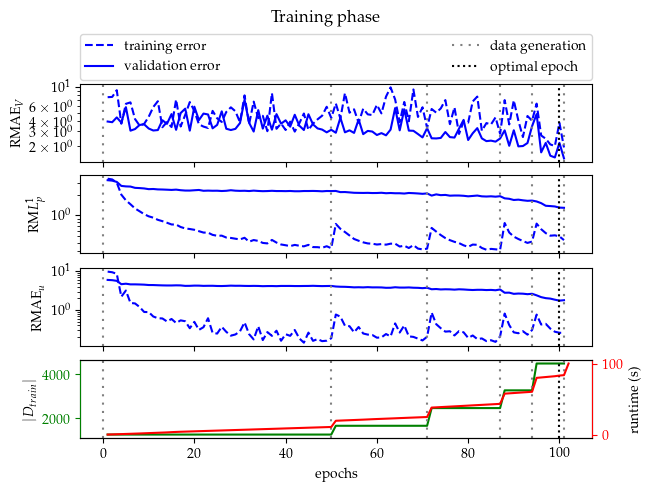

------------------------------------
 Training Statistics
------------------------------------
total training time:           101.240104
total number of training data: 4496

data generation occured at epochs 50, 71, 87, 94 with ratio 1.249802, 1.249849, 1.249696, 1.249847
total epochs: 101, optimal epoch: 100

training errors of optimal model:
value RMAE: 3.781395, grad RML1: 0.495096, ctrl RMAE: 0.258380
validation errors of optimal model:
value RMAE: 2.186920, grad RML1: 1.298519, ctrl RMAE: 1.756162



In [9]:
# plot errors, data set size and runtime in training phase
training.plot_training_phase(save=True, problem_type=problem_type, model_type=model_type, train_type=train_type)

# display training statistics
training.display_stats(save=True, problem_type=problem_type, model_type=model_type, train_type=train_type)

### Testing  model

In [10]:
# choose number of trajectories in test set
num_test_samples = 10

# load optimal model parameters
model = NN.load_model(problem_type, model_type, train_type)

# generate test data using NN warm start
X0_samples = data_generation.sample_X0(problem, num_samples=num_test_samples)
print('------------------------------------\n Test Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', 
                                                       init_config={'model':model})
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'test')

# compute test accuracy
test_data = data_generation.OCPDataset(problem_type, 'test')
if training.batch_size == 'full':
    test_dataloader = DataLoader(test_data, batch_size=len(test_data))
else:
    test_dataloader = DataLoader(test_data, batch_size=training.batch_size, shuffle=True)
print('------------------------------------\n Test Statistics\n------------------------------------')
print('test errors of optimal model:')
training.test_errors = np.hstack((training.test_errors, training.validate(test_dataloader, problem, model)))
training.add_test_stats(problem_type=problem_type, model_type=model_type, train_type=train_type)

------------------------------------
 Test Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 10 generating 3999 data points (from 2099 initially guessed points)
solution time:       43.970268 of which 24.975853 solving BVP
solution time per data point: 0.010995

------------------------------------
 Test Statistics
------------------------------------
test errors of optimal model:
value RMAE: 4.200455, grad RML1: 1.454278, ctrl RMAE: 2.406100


### Properties of data sets

In [11]:
# display properties of data sets
print('------------------------------------\n Training Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'train', save=True, model_type=model_type, train_type=train_type)

print('------------------------------------\n Validation Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'val', save=True, model_type=model_type, train_type=train_type)

print('------------------------------------\n Test Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'test', save=True, model_type=model_type, train_type=train_type)

------------------------------------
 Training Data Set
------------------------------------
number of trajectories: 15, number of data points: 5330

------------------------------------
 Validation Data Set
------------------------------------
number of trajectories: 5, number of data points: 1255

------------------------------------
 Test Data Set
------------------------------------
number of trajectories: 10, number of data points: 3999



### Simulation of NN, BVP, LQR solutions and uncontrolled system for specific initial condition

In [12]:
# name specific initial condition
init_type = 'sin'

# choose specific initial condition
#initial_condition = OCP.zero
#initial_condition = OCP.quadratic
#initial_condition = OCP.polynomial
initial_condition = OCP.sin
#initial_condition = OCP.quadratic_cos

# option to multiply initial condition with factor (scale or flip sign)
scale_factor = 1.

specific_X0 = scale_factor * initial_condition(problem.Omega_mesh[1:-1]).reshape(-1,1)

# get target
Y = problem.target(problem.Omega_mesh[1:-1]).reshape(-1,1)

# decide on methods for comparison (bilinear control does not allow for LQR)
methods = ['NN', 'LQR', 'BVP', 'unctrl'] 
if problem.ctrl == 'bilin' and 'LQR' in methods:
    methods.remove('LQR')

In [13]:
import NN_evaluation
import LQR
import simulation

# compute closed-loop NN solution
if 'NN' in methods:
    t_NN, X_NN = NN_evaluation.get_trajectory(problem, model, specific_X0)
    V_NN, P_NN, U_NN = NN_evaluation.get_data(model, t_NN, X_NN, get_U=True, problem=problem)

# compute closed-loop LQR solution
if 'LQR' in methods:
    if problem.target == OCP.zero:
        LQ_problem = LQR.LQProblem(problem)
    else:
        LQ_problem = LQR.LQProblemNonzeroTarget(problem)
    t_LQR, X_LQR = LQ_problem.get_trajectory(specific_X0)
    V_LQR, P_LQR, U_LQR = LQ_problem.get_data(t_LQR, X_LQR)
    
# compute open-loop BVP solution
if 'BVP' in methods:
    print('------------------------------------\n Specific Example Data Generation\n------------------------------------') 
    solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
    t_BVP, X_aug_BVP, _, X_aug_funs = BVP.solve_BVP(problem, specific_X0, initialization='NN_warm_start',
                                            init_config={'model':model}, solver_config=solver_config)
    X_BVP, V_BVP, P_BVP, U_BVP = data_generation.split_data(X_aug_BVP, get_U=True, problem=problem)
    
# compute uncontrolled dynamics 
if 'unctrl' in methods:
    ctrl = problem.ctrl
    problem.ctrl = None  
    print('--- Uncontrolled System ---')
    init_config = {'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}
    solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
    t_unctrl, X_aug_unctrl, _, _ = BVP.solve_BVP(problem, specific_X0, initialization='time_marching', 
                                                 init_config=init_config, solver_config=solver_config)
    X_unctrl, V_unctrl, P_unctrl, U_unctrl = data_generation.split_data(X_aug_unctrl, get_U=True, problem=problem)
    if not len(t_unctrl):
        methods.remove('unctrl')
    problem.ctrl = ctrl

------------------------------------
 Specific Example Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 227 data points (from 204 initially guessed points)
solution time:       2.968104 of which 1.108460 solving BVP
solution time per data point: 0.013075

--- Uncontrolled System ---


/home/eg/Desktop/Masterarbeit/programs/OCP.py:92: RuntimeWarning: overflow encountered in square
  R = self.b*X**2
/home/eg/Desktop/Masterarbeit/programs/OCP.py:171: RuntimeWarning: overflow encountered in multiply
  dRdx = 2*self.b*P*X
/home/eg/Desktop/Masterarbeit/programs/OCP.py:125: RuntimeWarning: overflow encountered in square
  return self.alpha*self.mesh_size*np.sum((X-Y)**2, axis=0, keepdims=True)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:309: RuntimeWarning: invalid value encountered in subtract
  0.125 * h * (f[:, 1:] - f[:, :-1]))
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:311: RuntimeWarning: invalid value encountered in add
  col_res = y[:, 1:] - y[:, :-1] - h / 6 * (f[:, :-1] + f[:, 1:] +
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:312: RuntimeWarning: overflow encountered in multiply
  4 * f_middle)
/home/eg/Desktop/Masterarbeit/programs/OCP.py:145: RuntimeWarning: overflow encountered i

number of fails:     1
fail time:           7.993058

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    



/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:592: RuntimeWarning: invalid value encountered in add
  t = (yp[:, :-1] + yp[:, 1:] - 2 * slope) / h
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:593: RuntimeWarning: overflow encountered in true_divide
  c[0] = t / h
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:594: RuntimeWarning: overflow encountered in subtract
  c[1] = (slope - yp[:, :-1]) / h - t
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:566: RuntimeWarning: invalid value encountered in true_divide
  r_middle /= 1 + np.abs(f_middle)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:567: RuntimeWarning: invalid value encountered in true_divide
  r1 /= 1 + np.abs(f1)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:568: RuntimeWarning: invalid value encountered in true_divide
  r2 /= 1 + np.abs(f2)
/home/eg/Desktop/Masterarbeit/programs/BVP

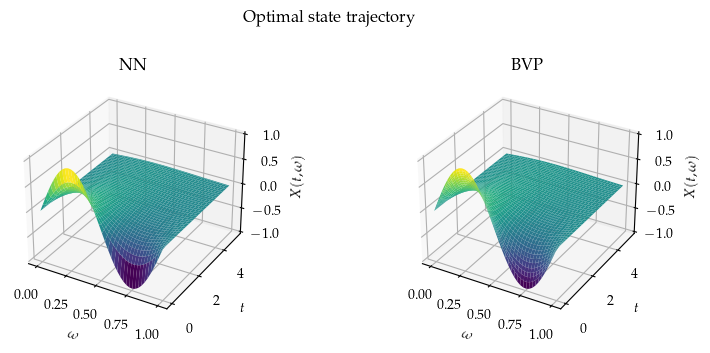

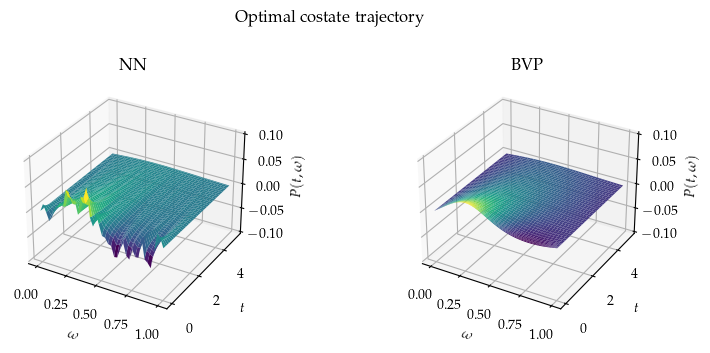

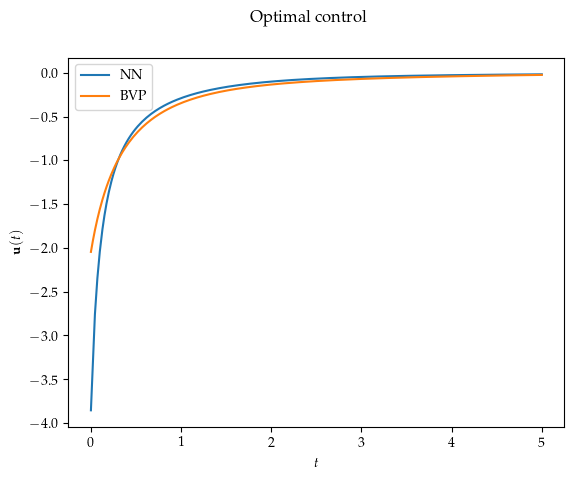

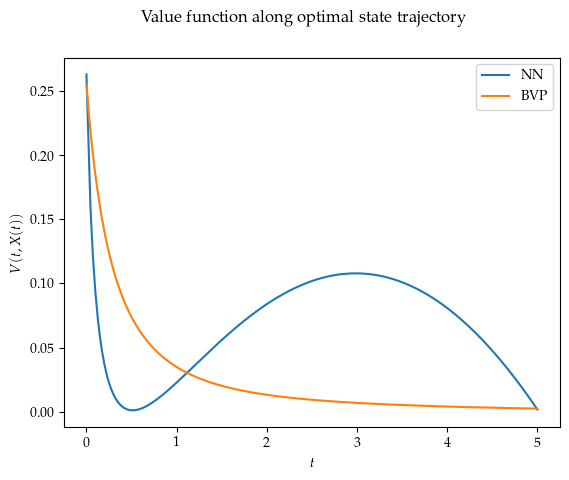

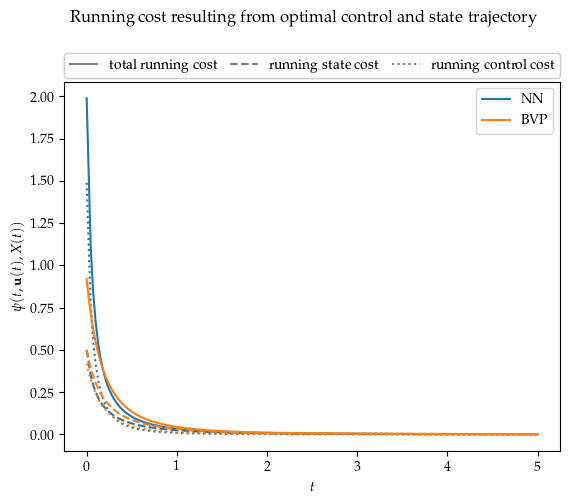

------------------------------------
 Costs of NN Solution
------------------------------------
running state cost:   0.124917
running control cost: 0.149451
total running cost:   0.274368
final cost:           0.001745
total cost:           0.276113

------------------------------------
 Costs of BVP Solution
------------------------------------
running state cost:   0.156186
running control cost: 0.096383
total running cost:   0.252569
final cost:           0.002427
total cost:           0.254996



In [14]:
# create directory for saving results
directory = simulation.get_directory(problem_type, model_type, train_type, init_type)

# plot optimal state trajectory
fig = plt.figure()
fig.suptitle('Optimal state trajectory', y=0.9)
axs = []
for num, method in enumerate(methods):                         
    axs.append(fig.add_subplot(1, len(methods), num + 1, projection='3d'))
    simulation.plot_X(eval('t_' + method), problem.Omega_mesh, eval('X_' + method), ax=axs[num])
    axs[num].set_title(method)
    axs[num].set_zlim(-1.,1.)
plt.subplots_adjust(left=0., bottom=0., right=1., top=1., wspace=0.6, hspace=0.0)
plt.savefig(directory + '/state.png', bbox_inches='tight')
plt.show()

# plot optimal costate trajectory
fig = plt.figure()
fig.suptitle('Optimal costate trajectory', y=0.9)
axs = []
for num, method in enumerate(methods):                         
    axs.append(fig.add_subplot(1, len(methods), num + 1, projection='3d'))
    simulation.plot_P(eval('t_' + method), problem.Omega_mesh, eval('P_' + method), ax=axs[num])
    axs[num].set_title(method)
    axs[num].set_zlim(-0.1,0.1)
plt.subplots_adjust(left=0., bottom=0., right=1., top=1., wspace=0.6, hspace=0.0)
plt.savefig(directory + '/costate.png', bbox_inches='tight')
plt.show()

# plot optimal control
fig = plt.figure()
fig.suptitle('Optimal control')
for method in methods:                         
    simulation.plot_U(eval('t_' + method), eval('U_' + method), label=method)
#plt.ylim(bottom=-5)
plt.legend()
plt.savefig(directory + '/control.png')
plt.show()

# plot value function along optimal state trajectory 
fig = plt.figure()
fig.suptitle('Value function along optimal state trajectory')
for method in methods:                         
    simulation.plot_V(eval('t_' + method), eval('V_' + method), label=method)
#plt.ylim(top=2.5)
plt.legend()
plt.savefig(directory + '/value_function.png')
plt.show()

# plot running cost resulting from optimal control and state trajectory 
fig = plt.figure()
fig.suptitle('Running cost resulting from optimal control and state trajectory', y=1.03)
for num, method in enumerate(methods):                         
    simulation.plot_running_cost(problem, eval('t_' + method), eval('U_' + method), eval('X_' + method), Y, 
                                 color='C' + str(num), label=method)
#plt.ylim(-1,5)
legend = plt.legend()
solid_line, = plt.plot([0],linestyle='-', color='gray')
dashed_line, = plt.plot([0],linestyle='--', color='gray')
dotted_line, = plt.plot([0],linestyle=':', color='gray')
legend_lines = plt.legend([solid_line, dashed_line, dotted_line], ['total running cost', 'running state cost', 'running control cost'], 
                          bbox_to_anchor=(0, 1.01, 1, 0.2), loc='lower left', mode='expand', borderaxespad=0, ncol=3)
plt.gca().add_artist(legend)
plt.gca().add_artist(legend_lines)
plt.savefig(directory + '/running_cost.png')
plt.show()

# display costs
for num, method in enumerate(methods): 
    append = False if num == 0 else True
    simulation.display_costs(problem, eval('t_' + method), eval('U_' + method), eval('X_' + method), Y, 
                             method=method, save=True, append=append, 
                             problem_type=problem_type, model_type=model_type, train_type=train_type, init_type=init_type)

### Testing BVP initialization for data generation

In [15]:
# sample initial conditions
X0_samples = data_generation.sample_X0(problem, num_samples=10)
solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}

# test simple initialization
print('------------------------------------\n Simple Initialization\n------------------------------------')
_ = BVP.solve_BVP(problem, X0_samples, solver_config=solver_config)
#print('\n--- Increased time steps ---')
#_ = BVP.solve_BVP(problem, X0_samples, init_config={'timesteps':100}, solver_config=solver_config)

# test time-marching
print('------------------------------------\n Time-Marching\n------------------------------------')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', solver_config=solver_config)
print('\n--- Adaptive time sequence ---')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                  init_config={'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}, 
                  solver_config=solver_config)
print('\n--- Equidistant time sequences with increased time steps ---')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                  init_config={'timeseq':30}, solver_config=solver_config)
#print('\n--- Equidistant time sequences with decreased time steps ---')
#_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
#                  init_config={'timeseq':5}, solver_config=solver_config)

# test NN warm start
print('------------------------------------\n NN Warm Start\n------------------------------------') 
_ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', 
                  init_config={'model':model}, solver_config=solver_config)

# test NN warm start with partially trained models
for partial_train_time in partial_train_times[:-1]:
    partial_train_type = train_type + 'PartialTrain' + str(partial_train_time)
    directory = NN.get_directory(problem_type, model_type, partial_train_type, make=False)
    if os.path.exists(directory):
        print(f'\n--- Partially trained model after time {partial_train_time} ---')
        partial_train_model = NN.load_model(problem_type, model_type, partial_train_type)
        _ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', init_config={'model':partial_train_model}, solver_config=solver_config)

------------------------------------
 Simple Initialization
------------------------------------


/home/eg/Desktop/Masterarbeit/programs/BVP.py:122: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/OCP.py:158: RuntimeWarning: overflow encountered in matmul
  U = -self.c/(2*self.beta) * np.diag(P.T @ X).reshape((1,-1))
/home/eg/Desktop/Masterarbeit/programs/OCP.py:92: RuntimeWarning: overflow encountered in square
  R = self.b*X**2
/home/eg/Desktop/Masterarbeit/programs/OCP.py:102: RuntimeWarning: overflow encountered in multiply
  S = self.c*U*X
/home/eg/Desktop/Masterarbeit/programs/OCP.py:104: RuntimeWarning: invalid value encountered in add
  return self.Q @ X + R + S
/home/eg/Desktop/Masterarbeit/programs/OCP.py:171: RuntimeWarning: overflow encountered in multiply
  dRdx = 2*self.b*P*X
/home/eg/Desktop/Masterarbeit/programs/OCP.py:179: RuntimeWarning: overflow encountered in multiply
  dSdx = self.c*U*P
/home/eg/Desktop/Masterarbeit/programs/OCP.py:181: RuntimeWarning: invalid valu

number of fails:     4
fail time:           83.322230

number of solutions: 6 generating 4869 data points (from 180 initially guessed points)
solution time:       49.184443 of which 49.183672 solving BVP
solution time per data point: 0.010102

------------------------------------
 Time-Marching
------------------------------------


/home/eg/Desktop/Masterarbeit/programs/BVP.py:81: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:81: RuntimeWarning: A singular Jacobian encountered when solving the collocation system.
  warnings.warn(sol.message, RuntimeWarning)


number of fails:     6
fail time:           206.364359

number of solutions: 4 generating 1010 data points (from 948 initially guessed points)
solution time:       18.173670 of which 3.248143 solving BVP
solution time per data point: 0.017994


--- Adaptive time sequence ---
number of fails:     0
fail time:           0.000000

number of solutions: 10 generating 2563 data points (from 2369 initially guessed points)
solution time:       43.838097 of which 8.235723 solving BVP
solution time per data point: 0.017104


--- Equidistant time sequences with increased time steps ---
number of fails:     0
fail time:           0.000000

number of solutions: 10 generating 2650 data points (from 2527 initially guessed points)
solution time:       104.367365 of which 8.667689 solving BVP
solution time per data point: 0.039384

------------------------------------
 NN Warm Start
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 10 genera